In [1]:
## built-in
import pdb
import time
import logging
from datetime import datetime

## 3rd
# torch
import torch
import torch.nn as nn
import torch.optim as optim
# from torch.optim import lr_scheduler

from torch.utils.data import DataLoader

# Custom
from models.deeplabv3 import deeplabv3_mobilenet_v3_large
from datasets import CustomDataset

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

In [2]:
device = torch.device(
    'cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
def collate_fn(batch):
    return tuple(zip(*batch))


config = dict(epochs=30, batch_size=1)

TRAIN_PROCESS = ['val']
TRAIN_JSON = {
    "val":
    f"/opt/ml/Git/final-project-level3-cv-10/data/sample.valid.json",
}

def get_train_transform():
    return A.Compose([
        A.Resize(480, 854),
        # A.RandomCrop(480, 640),
        A.HorizontalFlip(p=0.5),
        ToTensorV2()
    ])

defined_transforms = {
    'val': get_train_transform(),
}

recycle_dataset = {
    x: CustomDataset(
        data_json=TRAIN_JSON[x],
        transforms=defined_transforms[x],
    )
    for x in TRAIN_PROCESS
}

dataloaders = {
    x: DataLoader(
        recycle_dataset[x],
        batch_size=config['batch_size'],
        num_workers=1,
        pin_memory=True,
        collate_fn=collate_fn,
    )
    for x in TRAIN_PROCESS
}

_dataloader = iter(dataloaders['val'])

model = deeplabv3_mobilenet_v3_large()
model.to(device)
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()  # Set model to evaluate mode

# torch.save(model.state_dict(), 'model_weights.pth')

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


DeepLabV3(
  (backbone): Sequential(
    (0): Module(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): Module(
      (block): Module(
        (0): Module(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Module(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): Module(
      (block): Module(
        (0): Module(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_

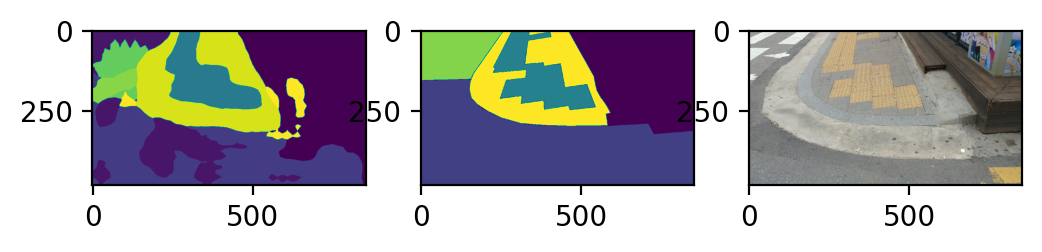

In [29]:
images, masks, image_infos = next(_dataloader)

images = torch.stack(images).to(device)
masks = torch.stack(masks).long().to(device)

outputs = model.forward(images)['out']

masks = masks.cpu().numpy()
# outputs = outputs.detach().cpu().numpy()
outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()

fig, axes = plt.subplots(1, 3, dpi=200)
axes[0].imshow(outputs[0])
axes[1].imshow(masks[0])
axes[2].imshow(images[0].cpu().numpy().transpose([1, 2, 0]))

In [10]:
dataset = recycle_dataset['val']

In [8]:
image_infos

[{'width': 1920,
  'height': 1080,
  'file_name': 'MP_SEL_SUR_026166.jpg',
  'license': '',
  'flickr_url': '',
  'coco_url': '',
  'date_captured': '',
  'id': 0}]

In [11]:
ann_ids = dataset.coco.getAnnIds(imgIds=image_infos[0]['id'])
anns = dataset.coco.loadAnns(ann_ids)

In [12]:
image_infos[0]['id']

0

In [13]:
ann_ids

[0, 1, 2, 3, 4, 5, 6]